In [2]:
from __future__ import division
import numpy as np
#import os, sys
import matplotlib
#matplotlib.use('Agg')
%matplotlib nbagg
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
import subprocess
from scipy.signal import periodogram

def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

# Extract and load DNS data using tshark and pandas

In [12]:
filename = '/Users/sgrover/Projects/IoT/data/IoT_long_dumps/nestcam_sharxcam_20160702_24hr.pcap'
outfile = '/Users/sgrover/Projects/IoT/oit-dns/processed/tshark_extract/nestcam_sharxcam_20160702_24hr.csv'

cmd = 'tshark -r '+filename+' -E separator="|" -T fields -e frame.time_relative \
-e ip.src -e ip.dst -e dns.qry.name -Y "dns.flags.response eq 0" > '+outfile

#subprocess.check_call(cmd, shell=True)

0

In [13]:
df = pd.read_csv('../processed/tshark_extract/nestcam_sharxcam_20160702_24hr.csv', sep='|',
                 names=['time', 'srcip', 'dstip', 'dnsquery'], )

df_dev1 = df[df['srcip']=="10.0.0.9"]
df_dev2 = df[df['srcip']=="10.0.0.8"]

# Print possible DNS queries

In [14]:
print len(df_dev1['dnsquery'].unique())

for query, d in df_dev1.groupby('dnsquery'):
    print len(d), query

2
20454 nexus.dropcam.com
41728 pool.ntp.org


In [15]:
print len(df_dev2['dnsquery'].unique())

for query, d in df_dev2.groupby('dnsquery'):
    print len(d), query

4
16582 ftp://homenetworklab.noise.gatech.edu:data/
16712 smtp.gmail.com
16264 time.nist.gov
5673 www.sharxsecurity.com


# Freq analysis of each DNS query

In [43]:
def get_period(df_dev):
    # separate each dns timeseries
    # make sure that particular DNS is present in AT LEAST half the total pcap time before getting period

    time_arr = list( df_dev['time'] )
    tot_time = time_arr[-1] - time_arr[0]
    print "tot time = ", tot_time

    for query, d in df_dev.groupby('dnsquery'):

        time_arr = list( d['time'] )
        dns_time = time_arr[-1] - time_arr[0]
        print "dns_time = ", dns_time

        if (dns_time >= tot_time/2) and len(d) > 10:
            #period, f, Pxx_den, y = extract_period(list(d['time']))

            x = np.array( list(d['time']) )
            Ts = np.min( np.diff(x) )/2
            print "min diff x = ", min(np.diff(x))
            # min Ts at least 1 second
            if Ts < 1.0:
                Ts = 1.0
            fs = 1.0/Ts
            print "Ts, fs = ", Ts, fs
            y = np.bincount((x/Ts).astype(int))

            f, Pxx_den = periodogram(y, fs)

            max_el = max([(v,i) for i,v in enumerate(Pxx_den)])
            period_freq = f[max_el[1]-1]
            period = 1.0 / period_freq 

            if (period <= tot_time/2):
                print len(d), dns_time, query
                print "period = ",period, "period_freq = ", period_freq

            if len(d)>20:
                fig1, axarr = plt.subplots(2)
                axarr[0].plot(range(len(y)), y, 'o')
                axarr[0].set_xlabel('timestamp (s)')
                axarr[0].set_ylabel('num of dns queries')

                axarr[1].plot(f, Pxx_den)
                axarr[1].set_xlabel('frequency [Hz]')
                axarr[1].set_ylabel('PSD [V**2/Hz]')

                plt.suptitle(query)

                fig1.show()
    return

## D03a NestCam

tot time =  86408.272651
dns_time =  86408.160012
min diff x =  0.00150700000086
Ts, fs =  1.0 1.0
20454 86408.160012 nexus.dropcam.com
period =  47.375 period_freq =  0.0211081794195


<IPython.core.display.Javascript object>


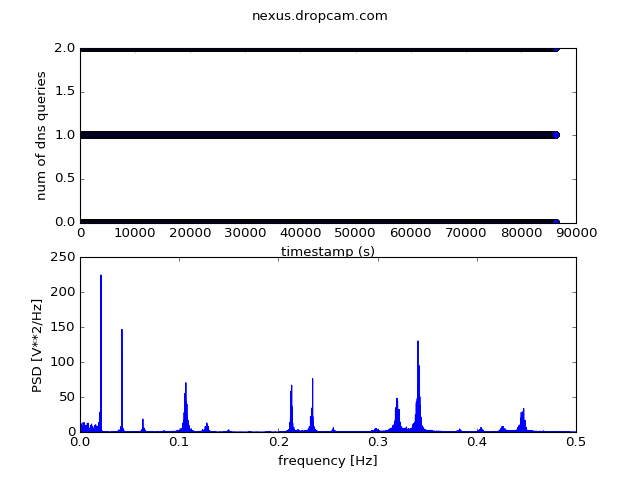

dns_time =  86408.182418
min diff x =  2.79999999293e-05
Ts, fs =  1.0 1.0
41728 86408.182418 pool.ntp.org
period =  47.3755482456 period_freq =  0.0211079351486


<IPython.core.display.Javascript object>


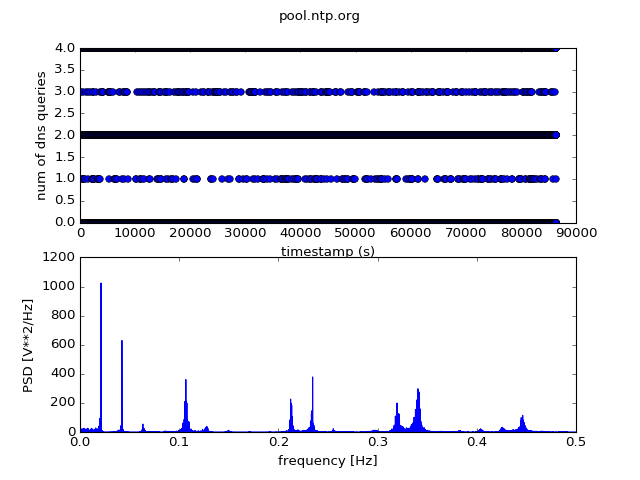

In [17]:
get_period(df_dev1)

## D04a SHARX SECURITY CAM

tot time =  86404.747509
dns_time =  86385.173985
min diff x =  0.00253000000157
Ts, fs =  1.0 1.0
16582 86385.173985 ftp://homenetworklab.noise.gatech.edu:data/
period =  5.11126227375 period_freq =  0.195646387613


<IPython.core.display.Javascript object>


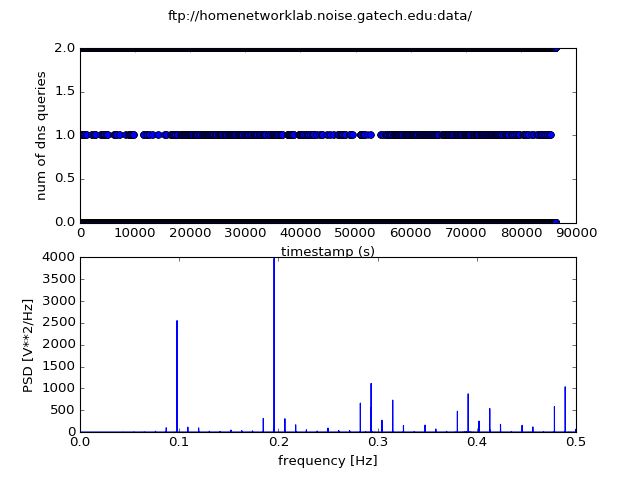

dns_time =  86385.34431
min diff x =  0.00254100000166
Ts, fs =  1.0 1.0
16712 86385.34431 smtp.gmail.com
period =  10.1709039548 period_freq =  0.0983196778225


<IPython.core.display.Javascript object>


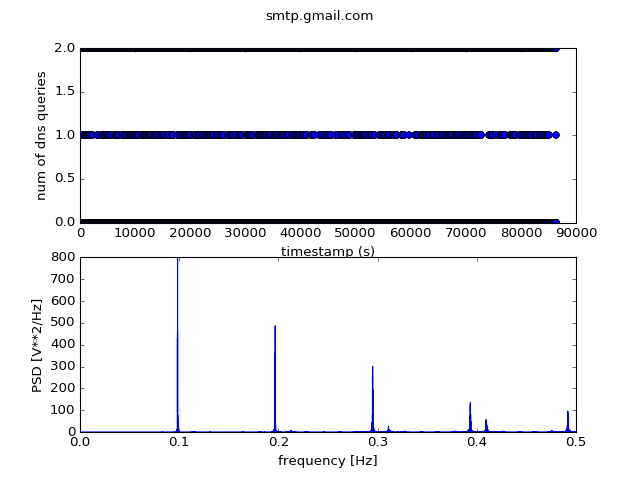

dns_time =  86404.747509
min diff x =  0.00254800000039
Ts, fs =  1.0 1.0
16264 86404.747509 time.nist.gov
period =  10.3862980769 period_freq =  0.0962806952577


<IPython.core.display.Javascript object>


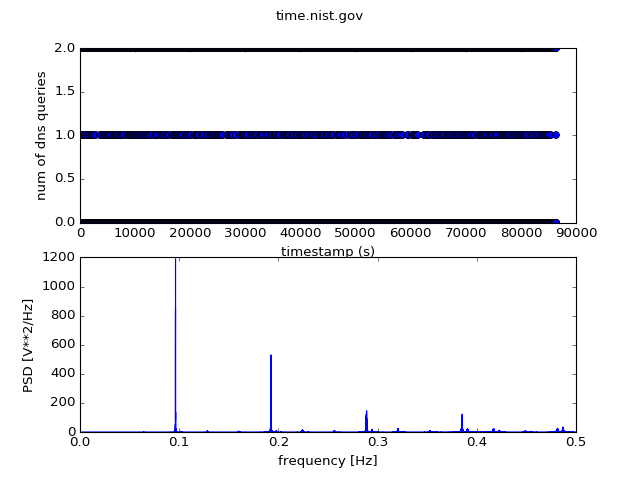

dns_time =  86349.061553
min diff x =  0.00254800000403
Ts, fs =  1.0 1.0
5673 86349.061553 www.sharxsecurity.com
period =  10.0222686152 period_freq =  0.0997778086377


<IPython.core.display.Javascript object>


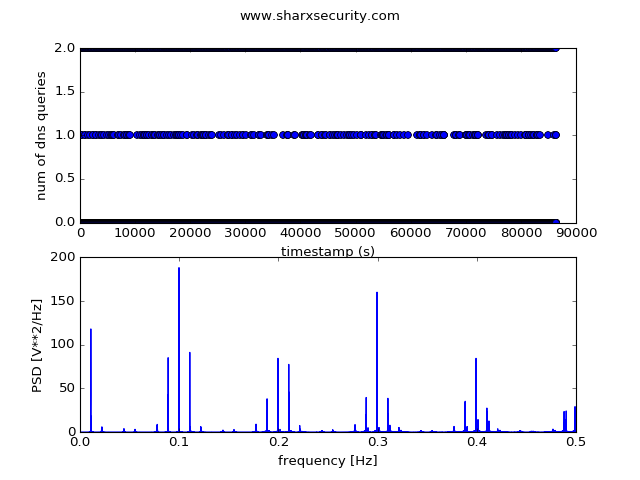

In [19]:
get_period(df_dev2)

## D03b NestCam active

In [45]:
filename = '/Users/sgrover/Projects/IoT/data/IoT_long_dumps/nestcam_sharxcam_motion_20160704_13hr.pcap'
outfile = '/Users/sgrover/Projects/IoT/oit-dns/processed/tshark_extract/nestcam_sharxcam_motion_20160704_13hr.csv'

cmd = 'tshark -r '+filename+' -E separator="|" -T fields -e frame.time_relative \
-e ip.src -e ip.dst -e dns.qry.name -Y "dns.flags.response eq 0" > '+outfile

#subprocess.check_call(cmd, shell=True)

0

In [47]:
df = pd.read_csv('../processed/tshark_extract/nestcam_sharxcam_motion_20160704_13hr.csv', sep='|',
                 names=['time', 'srcip', 'dstip', 'dnsquery'], )

df_dev1 = df[df['srcip']=="10.0.0.9"]
df_dev2 = df[df['srcip']=="10.0.0.8"]

In [48]:
print len(df_dev1['dnsquery'].unique())

for query, d in df_dev1.groupby('dnsquery'):
    print len(d), query

3
2 nexus.dropcam.com
2 oculus625-vir.dropcam.com
4 pool.ntp.org


In [49]:
get_period(df_dev1)

tot time =  0.64591
dns_time =  0.003105
dns_time =  0.003197
dns_time =  0.005602


## D04b SharxCam active

In [53]:
print len(df_dev2['dnsquery'].unique())

for query, d in df_dev2.groupby('dnsquery'):
    print len(d), query

4
58269 ftp://homenetworklab.noise.gatech.edu:data/
8569 smtp.gmail.com
2 time.nist.gov
725 www.sharxsecurity.com


tot time =  43470.261261
dns_time =  43448.945377
min diff x =  0.00240900000063
Ts, fs =  1.0 1.0
58269 43448.945377 ftp://homenetworklab.noise.gatech.edu:data/
period =  13.1451466586 period_freq =  0.0760737043086


<IPython.core.display.Javascript object>


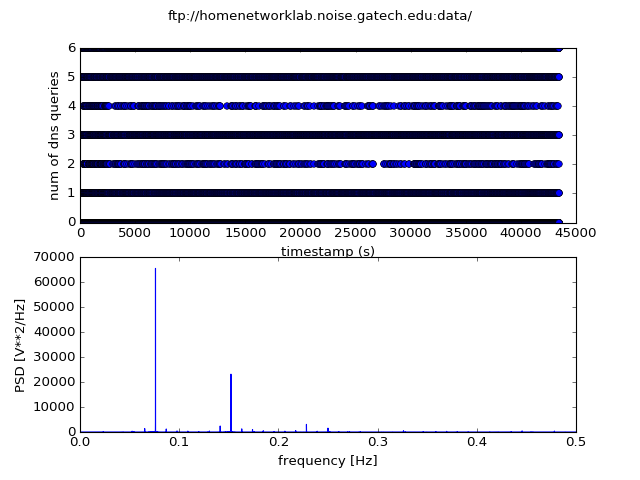

dns_time =  43449.420415
min diff x =  0.00300900000002
Ts, fs =  1.0 1.0
8569 43449.420415 smtp.gmail.com
period =  5.0187023782 period_freq =  0.199254692676


<IPython.core.display.Javascript object>


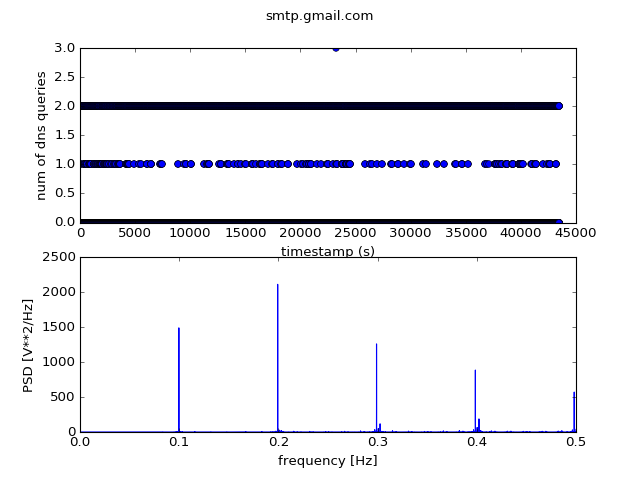

dns_time =  0.022172
dns_time =  43416.627219
min diff x =  0.015344
Ts, fs =  1.0 1.0
725 43416.627219 www.sharxsecurity.com
period =  60.132780083 period_freq =  0.016629864753


<IPython.core.display.Javascript object>


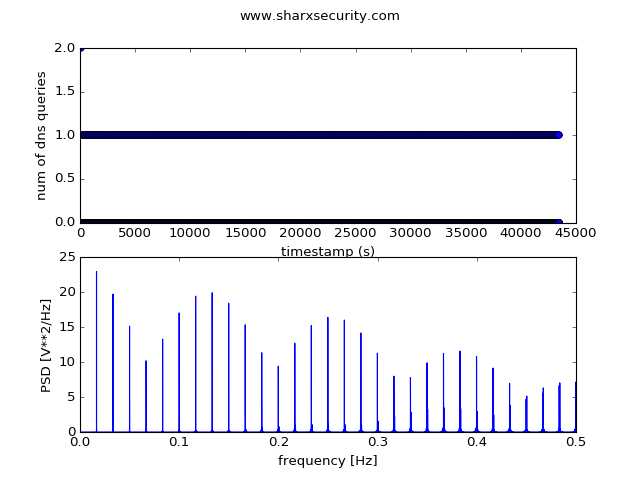

In [54]:
get_period(df_dev2)

## D03c NestCam active + view stream

In [58]:
# editcap -i 7200 nestcam_sharxcam_motion_viewstream_20160704_4hr.pcap nestcam_sharxcam_motion_viewstream_20160704_2hr.pcap

filename = '/Users/sgrover/Projects/IoT/data/IoT_long_dumps/nestcam_sharxcam_motion_viewstream_20160704_2hr_00001_20160704153626.pcap'
outfile = '/Users/sgrover/Projects/IoT/oit-dns/processed/tshark_extract/nestcam_sharxcam_motion_viewstream_20160704_2hr_00001_20160704153626.csv'

cmd = 'tshark -r '+filename+' -E separator="|" -T fields -e frame.time_relative \
-e ip.src -e ip.dst -e dns.qry.name -Y "dns.flags.response eq 0" > '+outfile

#subprocess.check_call(cmd, shell=True)

In [60]:
df = pd.read_csv('../processed/tshark_extract/nestcam_sharxcam_motion_viewstream_20160704_2hr_00001_20160704153626.csv', sep='|',
                 names=['time', 'srcip', 'dstip', 'dnsquery'], )

df_dev1 = df[df['srcip']=="10.0.0.9"]
df_dev2 = df[df['srcip']=="10.0.0.8"]

In [63]:
print len(df_dev1['dnsquery'].unique())

for query, d in df_dev1.groupby('dnsquery'):
    print len(d), query

0


In [65]:
#get_period(df_dev1)

## D04c SharxCam active + view stream (local?)

In [66]:
print len(df_dev2['dnsquery'].unique())

for query, d in df_dev2.groupby('dnsquery'):
    print len(d), query

3
9921 ftp://homenetworklab.noise.gatech.edu:data/
1436 smtp.gmail.com
120 www.sharxsecurity.com


tot time =  7198.328847
dns_time =  7195.67614
min diff x =  0.0031570000001
Ts, fs =  1.0 1.0
9921 7195.67614 ftp://homenetworklab.noise.gatech.edu:data/
period =  15.4154175589 period_freq =  0.0648701208501


<IPython.core.display.Javascript object>


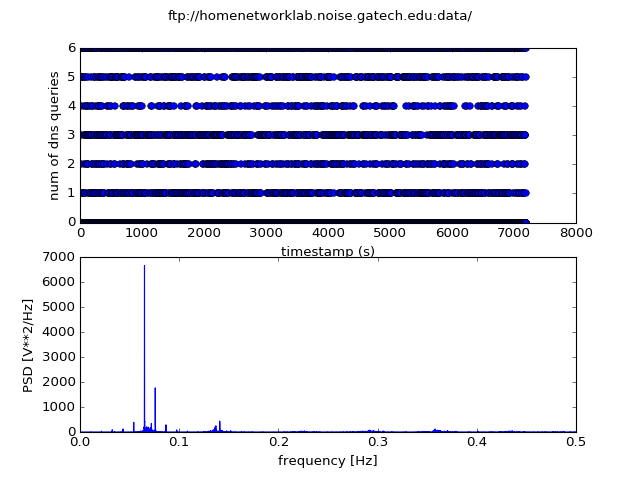

dns_time =  7197.642513
min diff x =  0.0138889999998
Ts, fs =  1.0 1.0
1436 7197.642513 smtp.gmail.com
period =  10.0544692737 period_freq =  0.0994582580914


<IPython.core.display.Javascript object>


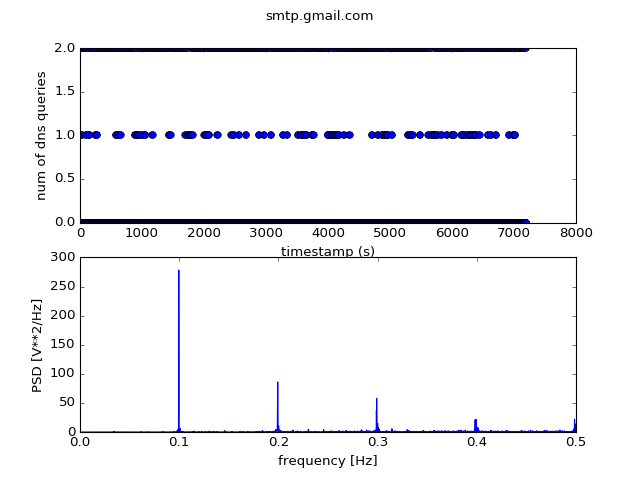

dns_time =  7152.386772
min diff x =  60.015904
Ts, fs =  30.007952 0.0333245001192
120 7152.386772 www.sharxsecurity.com
period =  60.5202393277 period_freq =  0.0165233979758


<IPython.core.display.Javascript object>


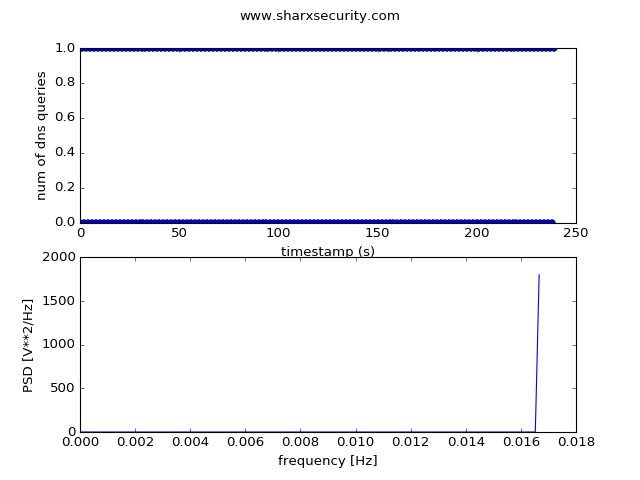

In [67]:
get_period(df_dev2)

## D05a SmartThings (alone)

In [ ]:
filename = '/Users/sgrover/Projects/IoT/data/IoT_long_dumps/smartthings_alone_20160702_4hr.pcap'
outfile = '/Users/sgrover/Projects/IoT/oit-dns/processed/tshark_extract/smartthings_alone_20160702_4hr.csv'

cmd = 'tshark -r '+filename+' -E separator="|" -T fields -e frame.time_relative \
-e ip.src -e ip.dst -e dns.qry.name -Y "dns.flags.response eq 0" > '+outfile

#subprocess.check_call(cmd, shell=True)

In [ ]:
df = pd.read_csv('../processed/tshark_extract/smartthings_alone_20160702_4hr.csv', sep='|',
                 names=['time', 'srcip', 'dstip', 'dnsquery'], )

df_dev1 = df[df['srcip']=="10.42.0.89"]

In [ ]:
print len(df_dev1['dnsquery'].unique())

for query, d in df_dev1.groupby('dnsquery'):
    print len(d), query

In [ ]:
get_period(df_dev1)

## D05b SmartThings + DoorSensor

In [20]:
filename = '/Users/sgrover/Projects/IoT/data/IoT_long_dumps/smartthings_doorsensor_20160703_14hr.pcap'
outfile = '/Users/sgrover/Projects/IoT/oit-dns/processed/tshark_extract/smartthings_doorsensor_20160703_14hr.csv'

cmd = 'tshark -r '+filename+' -E separator="|" -T fields -e frame.time_relative \
-e ip.src -e ip.dst -e dns.qry.name -Y "dns.flags.response eq 0" > '+outfile

#subprocess.check_call(cmd, shell=True)

In [29]:
df = pd.read_csv('../processed/tshark_extract/smartthings_doorsensor_20160703_14hr.csv', sep='|',
                 names=['time', 'srcip', 'dstip', 'dnsquery'], )

df_dev1 = df[df['srcip']=="10.42.0.89"]

In [32]:
print len(df_dev1['dnsquery'].unique())

for query, d in df_dev1.groupby('dnsquery'):
    print len(d), query

2
2 DC.connect.smartthings.com
94 pool.ntp.org


tot time =  54503.983529
dns_time =  53875.19738
dns_time =  54503.983529
min diff x =  5.995314
Ts, fs =  2.997657 0.333593870146
94 54503.983529 pool.ntp.org
period =  605.6599432 period_freq =  0.00165109152624


<IPython.core.display.Javascript object>


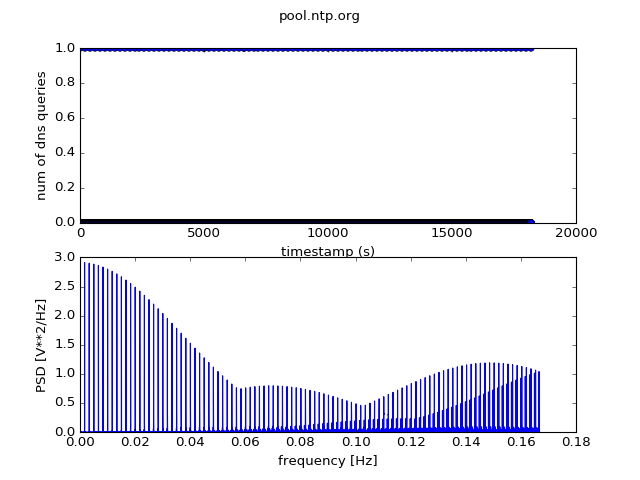

In [30]:
get_period(df_dev1)

## D05c Smartthings + Smartsocket

In [71]:
filename = '/Users/sgrover/Projects/IoT/data/IoT_long_dumps/smartthings_alone_20160702_4hr.pcap'
outfile = '/Users/sgrover/Projects/IoT/oit-dns/processed/tshark_extract/smartthings_alone_20160702_4hr.csv'

cmd = 'tshark -r '+filename+' -E separator="|" -T fields -e frame.time_relative \
-e ip.src -e ip.dst -e dns.qry.name -Y "dns.flags.response eq 0" > '+outfile

#subprocess.check_call(cmd, shell=True)

In [72]:
df = pd.read_csv('../processed/tshark_extract/smartthings_alone_20160702_4hr.csv', sep='|',
                 names=['time', 'srcip', 'dstip', 'dnsquery'], )

df_dev1 = df[df['srcip']=="10.42.0.89"]

In [73]:
print len(df_dev1['dnsquery'].unique())

for query, d in df_dev1.groupby('dnsquery'):
    print len(d), query

2
4 DC.connect.smartthings.com
30 pool.ntp.org


tot time =  13302.854139
dns_time =  117.819422
dns_time =  13302.854139
min diff x =  0.998185
Ts, fs =  1.0 1.0
30 13302.854139 pool.ntp.org
period =  120.963636364 period_freq =  0.00826694724185


<IPython.core.display.Javascript object>


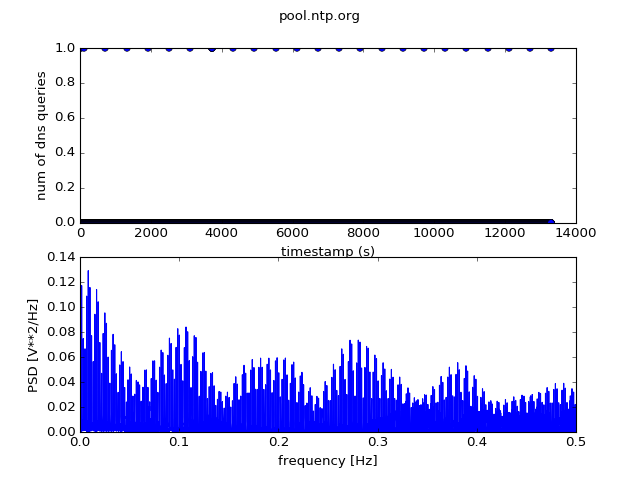

In [74]:
get_period(df_dev1)

## D05d Smartthings + Smartsocket + DoorSensor

In [38]:
filename = '/Users/sgrover/Projects/IoT/data/IoT_long_dumps/smartthings_smartsocket_doorsensor_20160706_14hr.pcap'
outfile = '/Users/sgrover/Projects/IoT/oit-dns/processed/tshark_extract/smartthings_smartsocket_doorsensor_20160706_14hr.csv'

cmd = 'tshark -r '+filename+' -E separator="|" -T fields -e frame.time_relative \
-e ip.src -e ip.dst -e dns.qry.name -Y "dns.flags.response eq 0" > '+outfile

#subprocess.check_call(cmd, shell=True)

0

In [39]:
df = pd.read_csv('../processed/tshark_extract/smartthings_smartsocket_doorsensor_20160706_14hr.csv', sep='|',
                 names=['time', 'srcip', 'dstip', 'dnsquery'], )

df_dev1 = df[df['srcip']=="10.42.0.89"]

In [41]:
print len(df_dev1['dnsquery'].unique())

for query, d in df_dev1.groupby('dnsquery'):
    print len(d), query

2
25 DC.connect.smartthings.com
115 pool.ntp.org


tot time =  59371.84414
dns_time =  41313.275684
min diff x =  3.442309
Ts, fs =  1.7211545 0.581005365875


<IPython.core.display.Javascript object>


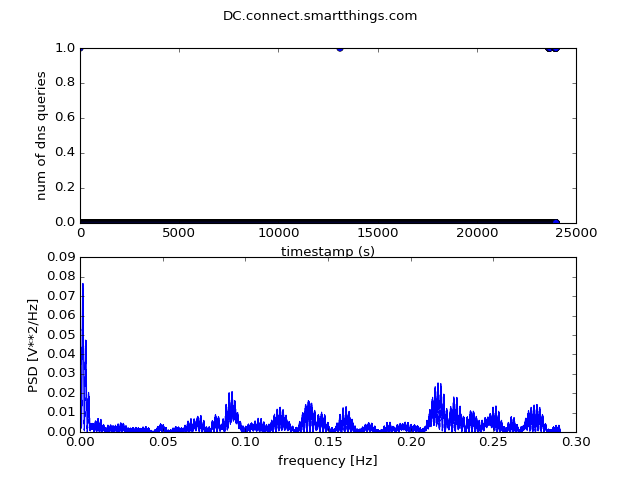

dns_time =  59371.84414
min diff x =  0.998211000002
Ts, fs =  1.0 1.0
115 59371.84414 pool.ntp.org
period =  605.867346939 period_freq =  0.00165052631579


<IPython.core.display.Javascript object>


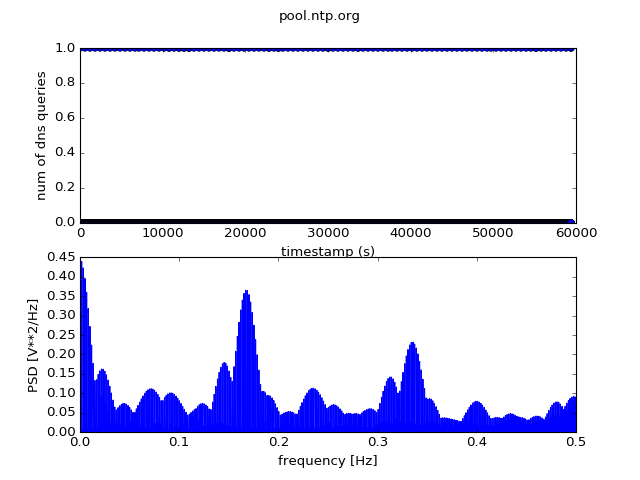

In [44]:
get_period(df_dev1)

## D01 Nest Thermostat bg

In [ ]:
filename = '/Users/sgrover/Projects/IoT/data/IoT-dumps/nest/1448061849.pcap'
outfile = '/Users/sgrover/Projects/IoT/oit-dns/processed/tshark_extract/nestthermo_homeuse_20151120_45hr.csv'

cmd = 'tshark -r '+filename+' -E separator="|" -T fields -e frame.time_relative \
-e ip.src -e ip.dst -e dns.qry.name -Y "dns.flags.response eq 0" > '+outfile

#subprocess.check_call(cmd, shell=True)

In [77]:
df = pd.read_csv('../processed/tshark_extract/nestthermo_homeuse_20151120_45hr.csv', sep='|',
                 names=['time', 'srcip', 'dstip', 'dnsquery'], )

df_dev1 = df[df['srcip']=="10.0.0.7"]

In [78]:
print len(df_dev1['dnsquery'].unique())

for query, d in df_dev1.groupby('dnsquery'):
    print len(d), query

5
6 frontdoor.nest.com
836 log-rts04-iad01.devices.nest.com
11 time.nest.com
297 transport01-rts04-iad01.transport.home.nest.com
225 weather.nest.com


tot time =  160969.112922
dns_time =  85223.243055
dns_time =  160739.02632
min diff x =  7.30000001568e-05
Ts, fs =  1.0 1.0
836 160739.02632 log-rts04-iad01.devices.nest.com
period =  30.0067101584 period_freq =  0.033325879269


<IPython.core.display.Javascript object>


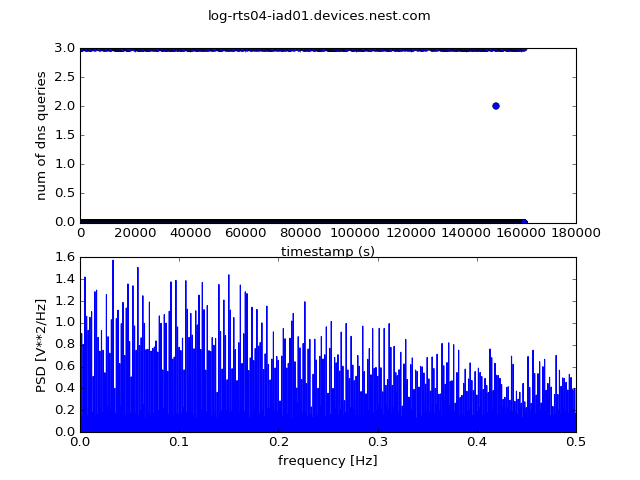

dns_time =  155075.449089
min diff x =  9.39999881666e-05
Ts, fs =  1.0 1.0
11 155075.449089 time.nest.com
period =  17.0019732515 period_freq =  0.0588167023444
dns_time =  160538.801956
min diff x =  7.49999890104e-05
Ts, fs =  1.0 1.0
297 160538.801956 transport01-rts04-iad01.transport.home.nest.com
period =  10.170257123 period_freq =  0.0983259309874


<IPython.core.display.Javascript object>


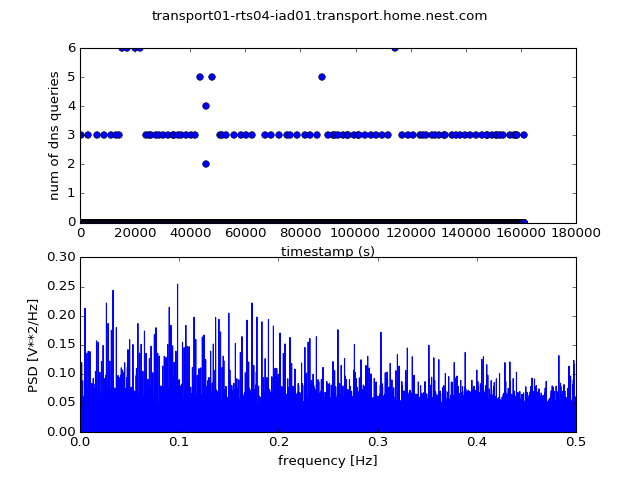

dns_time =  159017.446876
min diff x =  7.7999997302e-05
Ts, fs =  1.0 1.0
225 159017.446876 weather.nest.com
period =  30.0065481759 period_freq =  0.0333260591701


<IPython.core.display.Javascript object>


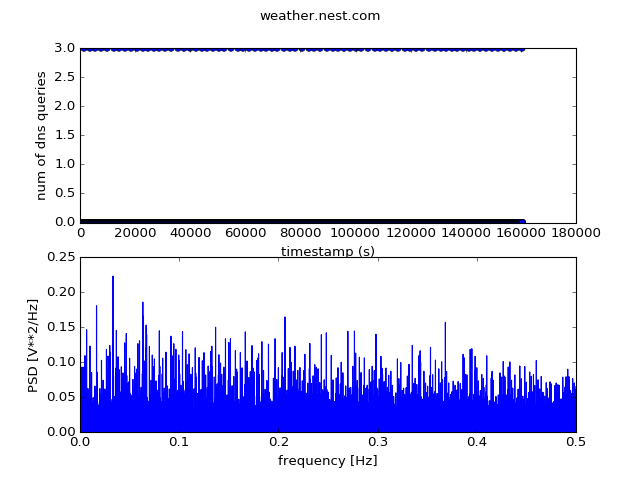

In [79]:
get_period(df_dev1)

## D02 Amazon Echo

In [81]:
filename = '/Users/sgrover/Projects/IoT/data/IoT-dumps/echo/1455151444.pcap'
outfile = '/Users/sgrover/Projects/IoT/oit-dns/processed/tshark_extract/echo_lab_20160211_16hr.csv'

cmd = 'tshark -r '+filename+' -E separator="|" -T fields -e frame.time_relative \
-e ip.src -e ip.dst -e dns.qry.name -Y "dns.flags.response eq 0" > '+outfile

#subprocess.check_call(cmd, shell=True)

In [84]:
df = pd.read_csv('../processed/tshark_extract/echo_lab_20160211_16hr.csv', sep='|',
                 names=['time', 'srcip', 'dstip', 'dnsquery'], )

df_dev1 = df[df['srcip']=="10.0.0.4"]

In [85]:
print len(df_dev1['dnsquery'].unique())

for query, d in df_dev1.groupby('dnsquery'):
    print len(d), query

15
6 0.north-america.pool.ntp.org
7 1.north-america.pool.ntp.org
6 2.north-america.pool.ntp.org
6 3.north-america.pool.ntp.org
588 amzdigitaldownloads.edgesuite.net
133 device-metrics-us.amazon.com
12 dp-449301NR._sftp-ssh._tcp.local,dp-449301NR.local,4.0.0.10.in-addr.arpa,dp-449301NR [74:75:48:9b:70:25]._workstation._tcp.local,dp-449301NR._ssh._tcp.local
1 esdk-ffl.spotify.com
8 ntp-g7g.amazon.com
405 ntp.amazon.com
16 pindorama.amazon.com
3 pins.amazon.com
6 softwareupdates.amazon.com
3 spectrum.s3.amazonaws.com
8 todo-ta-g7g.amazon.com


tot time =  60838.631843
dns_time =  5965.484575
dns_time =  5965.529494
dns_time =  5965.585472
dns_time =  5966.488474
dns_time =  5839.577997
dns_time =  59992.790122
min diff x =  0.00102599999991
Ts, fs =  1.0 1.0
133 59992.790122 device-metrics-us.amazon.com
period =  301.584158416 period_freq =  0.00331582403152


<IPython.core.display.Javascript object>


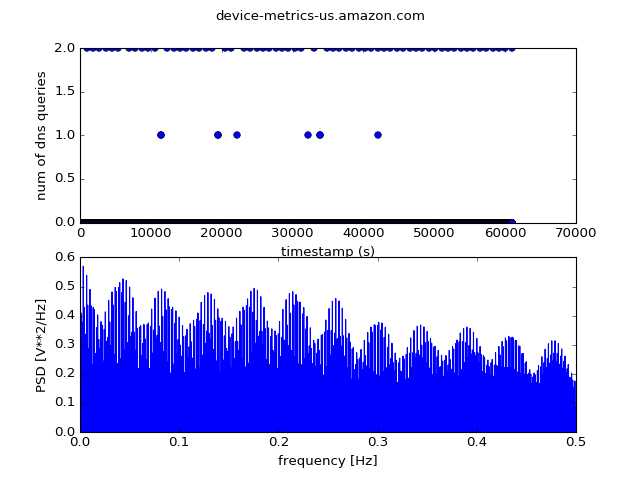

dns_time =  5950.463523
dns_time =  0.0
dns_time =  5965.48229
dns_time =  60697.962623
min diff x =  8.70000003488e-05
Ts, fs =  1.0 1.0
405 60697.962623 ntp.amazon.com
period =  633.125 period_freq =  0.00157946692991


/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


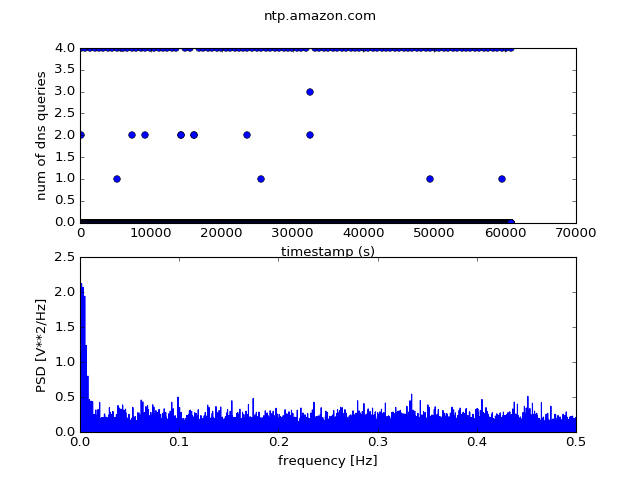

dns_time =  57996.080603
min diff x =  2123.350372
Ts, fs =  1061.675186 0.000941907669301
16 57996.080603 pindorama.amazon.com
period =  4491.70271 period_freq =  0.000222632721835
dns_time =  5951.324235
dns_time =  53882.881434
dns_time =  0.117834000001
dns_time =  5965.694405


In [86]:
get_period(df_dev1)